# CS446/519 - Class Session 10 - Closeness centrality

In this class session we are going to scatter plot the harmonic-mean closeness centralities
of the vertices in the gene regulatory network (from Pathway Commons) with the degree centralities.

## Closeness Centrality

Closeness centrality measures the mean distance from a vertex to other vertices.

A geodesic path is the shortest path between 2 vertices. Suppose $d_{ij}$ is the length of a geodesic path from vertex $i$ to $j$.

Mean geodesic distance of vertex $i$: $\ell_i = \frac{1}{n}\sum_j d_{ij}$

有些场合里会排除掉 $d_ii$，从而得到 $\ell_i = \frac{1}{n - 1}\sum_{j \neq i} d_{ij}$，但本质不影响，随便用哪个公式都行。书上用的是前面那个

Closeness Centrality $C_i = \frac{1}{\ell_i} = \frac{n}{\sum_j d_{ij}}$

Harmonic mean: 与一般的 mean = $\frac{\sum \limits_{i=1}^{n} x_i}{n}$ 不同，harmonic mean = $\frac{n}{\frac{1}{x_{1}} + \frac {1}{x_{2}} + \cdots + \frac{1}{x_{n}}} = \frac{n}{\sum \limits _{i=1}^{n} \frac{1}{x_{i}}}$

从 harmonic mean 出发，我们也可以定义 $C_i^{\prime} = \frac{1}{\ell_i} = \frac{1}{n-1} \sum_{j \neq i} \frac{1}{d_{ij}}$，但这个定义很少使用。

Mean geodesic distance between all pairs of vertices (in one component): $\ell = \frac{1}{n^2}\sum_{i,j} d_{ij} = \frac{1}{n} \sum_i \ell_i$

多个 components 的情况待补充

## Groups of vertices

clique: fully connected

- 注意 $k$-clique 并不是 clique
- $k$-clique 只要求任意两点有 path 且长度 $\leq k$
- $1$-clique $\iff$ clique

Less stringently, A $k$-plex of size $n$ is a maximal connected subgraph of $n$ vertices in $G$  such that each vertex is connected to at least $n-k$ vertices.

- $1$-plex $\iff$ clique
- 注意是 at least $n-k$，所以 $1$-plex 一定是 $2$-plex，依此类推

A $k$-core of a graph $G$ is a maximal connected subgraph of $G$ in which all vertices have degree at least $k$

- A $k$-core of $n$ vertices is also an $(n-k)$-plex

$k$-component: 待整理

Load in the SIF file for Pathway Commons

In [6]:
import pandas
sif_data = pandas.read_csv("shared/pathway_commons.sif",
                           sep="\t", names=["species1","interaction_type","species2"])

Restrict the rows of the dataframe to "controls-expression-of", and eliminate redundant edges in the edge-list. Note that this is a directed graph, so A->B and B->A are separate edges.

In [7]:
interac_grn = sif_data[sif_data.interaction_type == "controls-expression-of"]
interac_grn_unique = interac_grn[["species1","species2"]].drop_duplicates()

Create a directed graph in igraph, from the dataframe edge-list, using `Graph.TupleList`

In [8]:
import igraph
from igraph import Graph
grn_igraph = Graph.TupleList(interac_grn_unique.values.tolist(), directed=True)
grn_igraph.summary()

'IGRAPH DN-- 14208 110013 -- \n+ attr: name (v)'

For one vertex at a time, compute that vertex's harmonic mean closeness centrality using Eq. 7.30 from Newman's book. Don't forget to eliminate the "0" distance between a vertex and itself, in the results you get back from calling `shortest_paths`.  VERY IMPORTANT: make sure you specify a single source vertex to the `shortest_paths` function!  Just for information purposes, measure how long the code takes to run in seconds. Make sure to pass `mode=igraph.ALL` to `shortest_paths`, which will find paths regardless of edge direction.

In [15]:
import numpy
import timeit
N = len(grn_igraph.vs)
closeness_centralities = numpy.zeros(N)
ctr = 0
start_time = timeit.default_timer()
for my_vertex in grn_igraph.vs:
    my_dists = numpy.array(my_vertex.shortest_paths(mode=igraph.ALL))
    my_dists = my_dists[numpy.isfinite(my_dists) & (my_dists > 0)]
    if len(my_dists) > 0:
        closeness_centralities[ctr] = numpy.sum(1/my_dists)/(N-1)
    ctr += 1
ci_elapsed = timeit.default_timer() - start_time
print(ci_elapsed)

135.5354469390586


Histogram the harmonic-mean closeness centralities

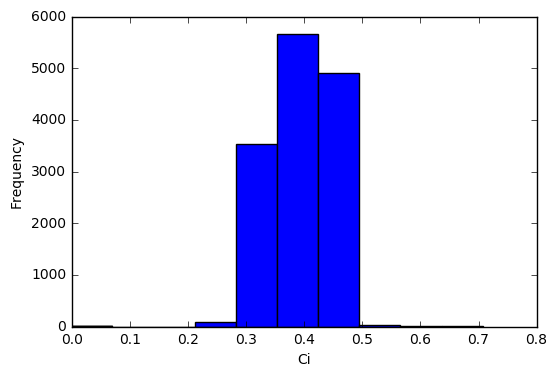

In [77]:
import matplotlib.pyplot
matplotlib.pyplot.hist(closeness_centralities)
matplotlib.pyplot.xlabel("Ci")
matplotlib.pyplot.ylabel("Frequency")
matplotlib.pyplot.show()

Scatter plot the harmonic-mean closeness centralities vs. the log10 degree

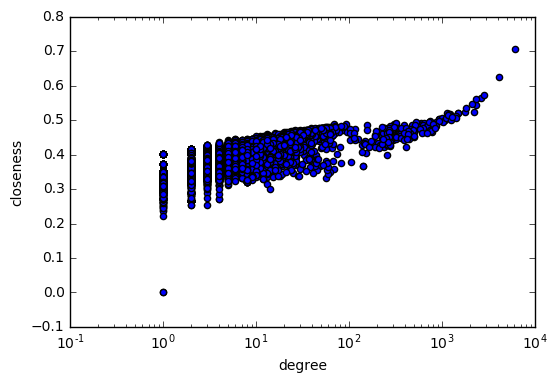

In [88]:
ax = matplotlib.pyplot.gca()
ax.scatter(grn_igraph.degree(), closeness_centralities)
ax.set_xscale("log")
matplotlib.pyplot.xlabel("degree")
matplotlib.pyplot.ylabel("closeness")
matplotlib.pyplot.show()

which protein has the highest closeness centrality in the network?

In [91]:
print(numpy.max(closeness_centralities))
grn_igraph.vs[numpy.argmax(closeness_centralities)]

0.707169001197


igraph.Vertex(<igraph.Graph object at 0x7fca66fe3d68>, 169, {'name': 'CYP26A1'})